# Camera calibration using CHARUCO

In [22]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg


## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

<IPython.core.display.Javascript object>


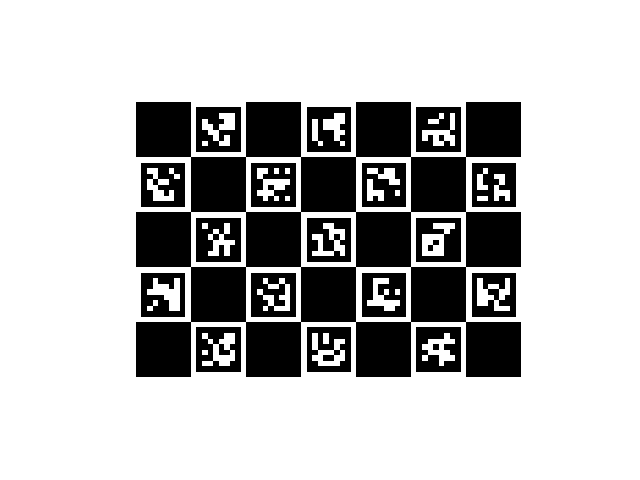

In [23]:
workdir = "./workdir/"
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite(workdir + "chessboard.tiff", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()


And take photos of it from multiple angles, for example:

<IPython.core.display.Javascript object>


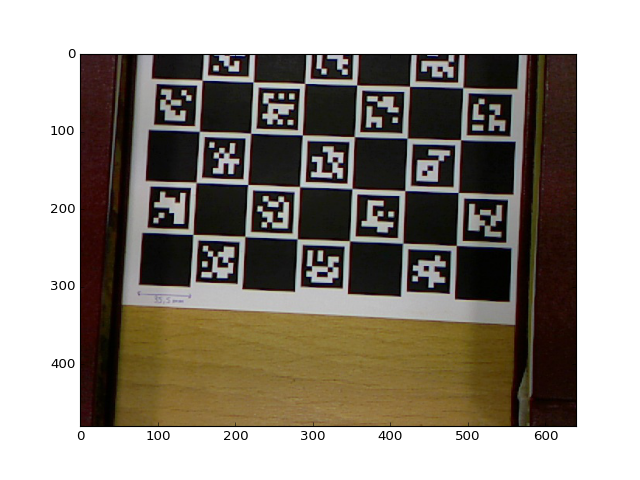

In [24]:
datadir = "../../data/calib_webcam/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [25]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (20,20), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [26]:
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image ../../data/calib_webcam/image_0.jpg
=> Processing image ../../data/calib_webcam/image_1.jpg
=> Processing image ../../data/calib_webcam/image_2.jpg
=> Processing image ../../data/calib_webcam/image_3.jpg
=> Processing image ../../data/calib_webcam/image_4.jpg
=> Processing image ../../data/calib_webcam/image_5.jpg
=> Processing image ../../data/calib_webcam/image_6.jpg
=> Processing image ../../data/calib_webcam/image_7.jpg
=> Processing image ../../data/calib_webcam/image_8.jpg
=> Processing image ../../data/calib_webcam/image_9.jpg
=> Processing image ../../data/calib_webcam/image_10.jpg
=> Processing image ../../data/calib_webcam/image_11.jpg
=> Processing image ../../data/calib_webcam/image_12.jpg
=> Processing image ../../data/calib_webcam/image_13.jpg
=> Processing image ../../data/calib_webcam/image_14.jpg
=> Processing image ../../data/calib_webcam/image_15.jpg
=> Processing image ../../data/calib_webcam/image_16.jpg
=> Processing ima

In [27]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [28]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 36.8 s, sys: 22.3 s, total: 59.1 s
Wall time: 15.7 s


In [29]:
ret

2.581475093169884

In [30]:
mtx

array([[1.02021933e+03, 0.00000000e+00, 3.05346289e+02],
       [0.00000000e+00, 1.05524064e+03, 3.33841599e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [32]:
dist

array([[-2.41506625e+00],
       [-3.35440635e+00],
       [ 7.36605241e-02],
       [ 2.22106812e-02],
       [ 6.70756547e+02],
       [-1.57098791e+00],
       [-2.25433272e+01],
       [ 8.00622188e+02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

### Check calibration results

<IPython.core.display.Javascript object>


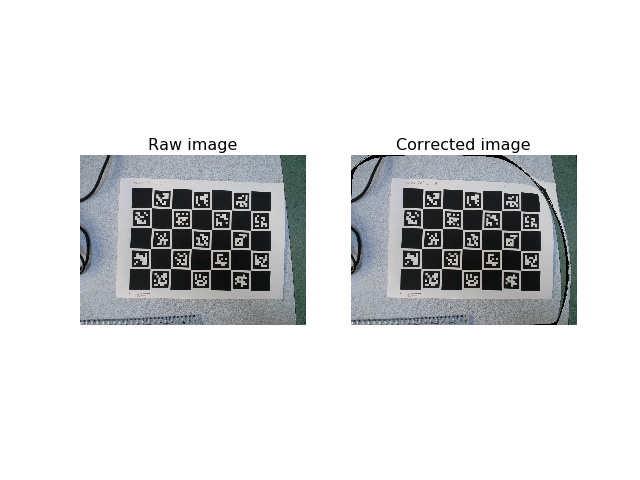

In [36]:
i=0 # select image id
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## 3 . Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

<IPython.core.display.Javascript object>


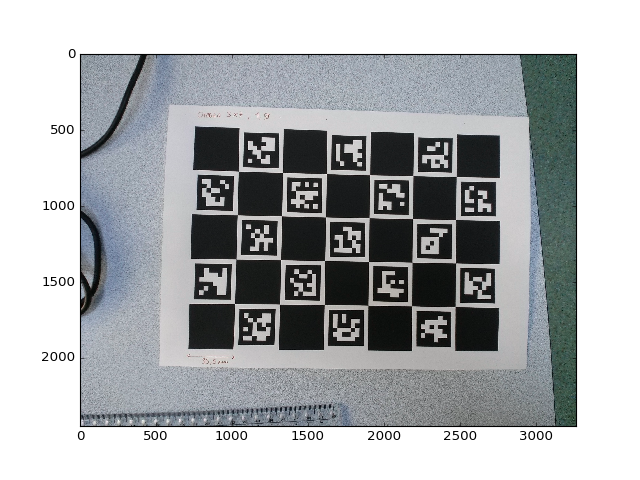

In [124]:

frame = cv2.imread(images[0])
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

## Post processing

In [125]:

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (5,5), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

corners

[array([[[1047.402 , 1677.9854],
         [1283.8707, 1680.0746],
         [1276.6002, 1916.945 ],
         [1038.5194, 1915.0704]]], dtype=float32),
 array([[[1643.643 , 1108.2988],
         [1872.287 , 1112.7354],
         [1869.3154, 1340.0709],
         [1640.2269, 1336.1356]]], dtype=float32),
 array([[[1361.5458 ,  816.6207 ],
         [1590.9443 ,  822.59094],
         [1587.4158 , 1049.6078 ],
         [1357.7041 , 1044.2266 ]]], dtype=float32),
 array([[[2507.,  850.],
         [2721.,  852.],
         [2725., 1064.],
         [2506., 1063.]]], dtype=float32),
 array([[[2209.549 , 1693.0295],
         [2437.6775, 1696.974 ],
         [2437.3079, 1928.5906],
         [2209.134 , 1925.7533]]], dtype=float32),
 array([[[1634.5605, 1684.4054],
         [1864.5225, 1686.7997],
         [1862.7523, 1921.8263],
         [1630.348 , 1919.4214]]], dtype=float32),
 array([[[2497.2854, 1410.262 ],
         [2726.4668, 1414.9214],
         [2723.777 , 1644.2507],
         [2495.574 , 1639

Very fast processing !

## Results

<IPython.core.display.Javascript object>


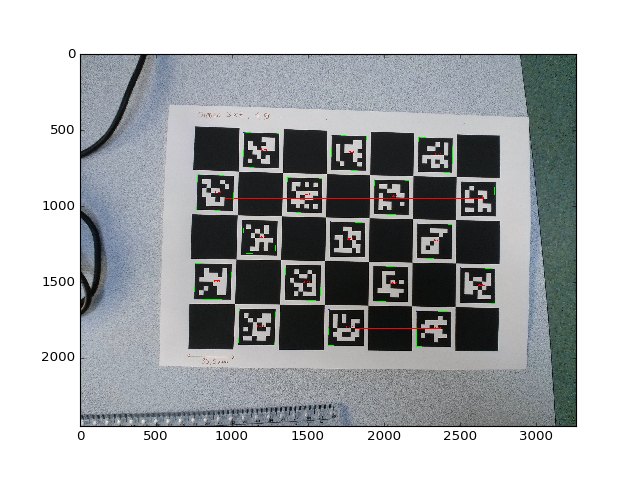

In [126]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Add local axis on each marker

In [127]:
size_of_marker =  0.0285 # side lenght of the marker in meter
rvecs,tvecs = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [128]:
length_of_axis = 0.02
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


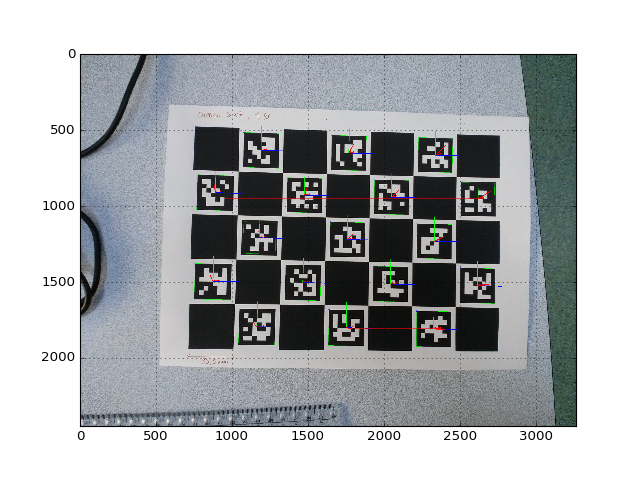

In [130]:
plt.figure()
plt.imshow(imaxis)
plt.grid()
plt.show()

In [131]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
datar = pd.DataFrame(data = tvecs.reshape(len(rvecs),3), columns = ["rx", "ry", "rz"], 
                    index = ids.flatten())
datar.index.name = "marker"
datar.sort_index(inplace= True)
np.degrees(datar)

,rx,ry,rz
marker,,,
0,-0.371357,-7.212711,21.281644
1,3.729082,-7.210358,21.666903
2,7.852785,-7.172673,21.919437
3,-2.425268,-5.132375,20.729973
4,1.647591,-5.203845,21.507475
5,5.781509,-5.179774,21.844798
6,10.426066,-5.385550,23.163378
7,-0.492406,-3.479132,23.108578
8,3.674880,-3.160688,21.639878


In [116]:
v = data.loc[3:6].values
((v[1:] - v[:-1])**2).sum(axis = 1)**.5

array([0.07247715, 0.07235671, 0.07102116])

In [139]:
cv2.Rodrigues(rvecs[0], np.zeros((3,3)))

(array([[ 0.99362566,  0.02736779, -0.10935749],
        [ 0.00425153, -0.97849066, -0.20624733],
        [-0.11264982,  0.2044677 , -0.97236977]]),
 array([[ 0.00367594, -0.0625552 ,  0.01774466,  0.05511376, -0.2054306 ,
          0.97575197,  0.03450362, -0.9747257 , -0.20896037],
        [-0.01076324,  0.67264604,  0.07054117,  0.67358929,  0.00914596,
         -0.02950556, -0.0695149 , -0.04626453, -0.00167504],
        [ 0.07557143, -0.06627069,  0.67005951,  0.06729696,  0.01156224,
         -0.05346701,  0.66911627,  0.06420195, -0.06401741]]))

<IPython.core.display.Javascript object>


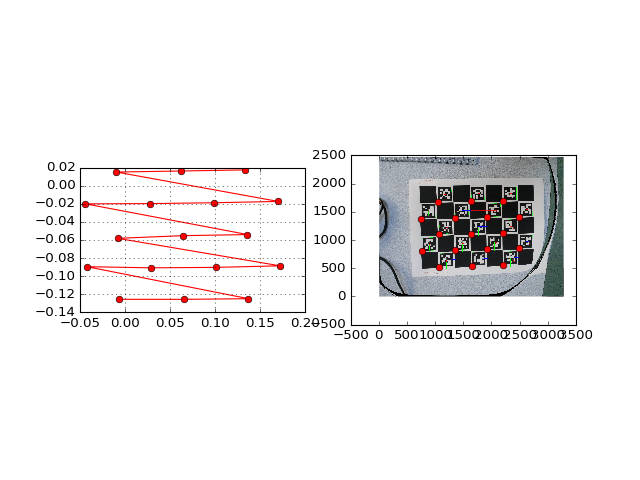

In [117]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "lower")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()

In [66]:
a = np.arange(50)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [291]:
import pickle

In [273]:
f = open("truc.pckl", "wb")
pickle.dump(a, f)
f.close()

In [274]:
f = open("truc.pckl", "rb")
b = pickle.load(f)
b == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [137]:
corners = np.array(corners)
data2 = pd.DataFrame({"px": corners[:, 0, 0, 1], 
                      "py": corners[:, 0, 0, 0]}, index = ids.flatten())
data2.sort_index(inplace=True)
data2

,px,py
0,177.324295,222.723907
1,174.117722,448.426971
5,165.167435,1385.455933
6,292.872223,348.533112
7,290.211761,572.901550
8,286.861359,800.593140
9,285.043823,1029.405640
10,284.054932,1261.753418
11,406.743347,250.763550
12,405.577484,469.121307


In [321]:
m0 = data2.loc[0]
m43 = data2.loc[43]
d01 = ((m0 - m43).values**2).sum()**.5
d = 42.5e-3 * (3.5**2 + 4.5**2)**.5
factor = d / d01
data2["x"] = data2.px * factor
data2["y"] = data2.py * factor
((data2[["x", "y"]].loc[11] - data2[["x", "y"]].loc[0]).values**2).sum()**.5


0.043476117957396747

In [347]:

c = np.array(corners).astype(np.float64).reshape(44,4,2)
(((c[:, 1:] - c[:, :-1])**2).sum(axis = 2)**.5).mean(axis =1)

array([ 138.33575835,  143.00113377,  142.012097  ,  140.69699432,
        146.66782406,  144.02442319,  138.67845434,  142.33812925,
        143.00229095,  140.33926025,  140.35356753,  146.66786569,
        139.34054504,  146.67222201,  140.03570454,  148.01939184,
        143.35647769,  142.67236143,  147.01931296,  148.02127735,
        137.67392157,  135.35308209,  141.00354688,  143.67946992,
        137.67149733,  138.67392207,  145.00112611,  142.33454105,
        138.3466791 ,  143.00234925,  139.0035972 ,  143.00115739,
        143.6865917 ,  144.67964727,  144.33446711,  141.67253496,
        143.67117097,  147.67232772,  150.35663387,  141.70034559,
        149.01342342,  146.01949591,  144.34013329,  150.35333222])

In [343]:
c

array([[[ 2406.,  1940.],
        [ 2546.,  1940.],
        [ 2545.,  2075.],
        [ 2405.,  2076.]],

       [[ 1991.,  1938.],
        [ 2138.,  1939.],
        [ 2138.,  2076.],
        [ 1993.,  2076.]],

       [[ 1584.,  1936.],
        [ 1728.,  1936.],
        [ 1731.,  2073.],
        [ 1586.,  2072.]],

       [[ 2619.,  1735.],
        [ 2759.,  1735.],
        [ 2754.,  1878.],
        [ 2615.,  1877.]],

       [[ 2198.,  1734.],
        [ 2347.,  1734.],
        [ 2346.,  1878.],
        [ 2199.,  1878.]],

       [[  973.,  1733.],
        [ 1117.,  1731.],
        [ 1121.,  1874.],
        [  976.,  1875.]],

       [[  572.,  1732.],
        [  710.,  1732.],
        [  713.,  1874.],
        [  577.,  1873.]],

       [[ 2410.,  1533.],
        [ 2554.,  1533.],
        [ 2552.,  1672.],
        [ 2408.,  1672.]],

       [[ 1373.,  1326.],
        [ 1519.,  1325.],
        [ 1519.,  1463.],
        [ 1374.,  1464.]],

       [[ 1785.,  1326.],
        [ 1926.,  13

In [11]:
help(cv2.aruco.detectMarkers)

Help on built-in function detectMarkers:

detectMarkers(...)
    detectMarkers(image, dictionary[, corners[, ids[, parameters[, rejectedImgPoints]]]]) -> corners, ids, rejectedImgPoints

